In [ ]:
from fastai.collab import *
from fastai.tabular import *

## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [ ]:
user,item,title = 'userId','movieId','title'

In [ ]:
URLs

In [ ]:
path = untar_data(URLs.ML_SAMPLE)
path

In [10]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


That's all we need to create and train a model:

In [11]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [12]:
y_range = [0,5.5]

In [13]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [14]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,1.584780,0.910530,00:01
1,0.844646,0.680814,00:00
2,0.662494,0.676538,00:00


## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [19]:
path=Config.data_path()/'ml-100k'

In [17]:
path=Path('data/ml-100k/')

In [20]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [21]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [22]:
len(ratings)

100000

In [23]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [25]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [26]:
data.show_batch()

userId,title,target
621,Babe (1995),5.0
291,Hot Shots! Part Deux (1993),4.0
561,Delicatessen (1991),5.0
435,Mimic (1997),3.0
7,Stargate (1994),3.0


In [27]:
y_range = [0,5.5]

In [ ]:
Learner

In [28]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


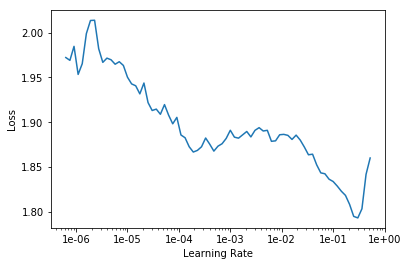

In [29]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [30]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.941741,0.950002,00:07
1,0.855088,0.879707,00:07
2,0.787759,0.834357,00:07
3,0.640518,0.814028,00:07
4,0.559045,0.814051,00:07


In [31]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [32]:
learn.load('dotprod');

In [33]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [37]:
rating_movie.groupby(title)['rating']

IndexError: Column(s) rating already selected

In [34]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie bias

In [38]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [39]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [40]:
item0 = lambda o:o[0]

In [41]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3776),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3000),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2934), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2723), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2565), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2560), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2422), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2344), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2308), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2235), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2169),
  'Tales from the Crypt Presents: Bordello of Blood (1996)',
  2.6363636363636362),
 (tensor(-0.2135), 'Jungle2Jungle (1997)', 2.4393939393939394),
 (tensor(-0.2119), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2047), 'Showgirls (1995)', 1.9

In [42]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.6522), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5764), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5677), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5496), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5436), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5427), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5138), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5072), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4956), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4825), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4799), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4782), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4743), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4649), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.4576), 'Godfather, The (1972)', 4.283292978208232)]

### Movie weights

In [43]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [44]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [45]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [46]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.3479), 'Home Alone 3 (1997)'),
 (tensor(1.1951), 'Jungle2Jungle (1997)'),
 (tensor(1.1795), 'D3: The Mighty Ducks (1996)'),
 (tensor(1.1726), "McHale's Navy (1997)"),
 (tensor(1.1445), 'Children of the Corn: The Gathering (1996)'),
 (tensor(1.1441), 'Bio-Dome (1996)'),
 (tensor(1.1305), 'Free Willy 3: The Rescue (1997)'),
 (tensor(1.1223), 'Congo (1995)'),
 (tensor(1.1109), 'Grease 2 (1982)'),
 (tensor(1.0657), 'Richie Rich (1994)')]

In [47]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1179), 'Wrong Trousers, The (1993)'),
 (tensor(-1.0850), 'Close Shave, A (1995)'),
 (tensor(-1.0832), 'Chinatown (1974)'),
 (tensor(-1.0485), 'Casablanca (1942)'),
 (tensor(-1.0269), 'Lawrence of Arabia (1962)'),
 (tensor(-0.9917), 'Third Man, The (1949)'),
 (tensor(-0.9873),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(-0.9714), 'Some Folks Call It a Sling Blade (1993)'),
 (tensor(-0.9625), 'When We Were Kings (1996)'),
 (tensor(-0.9501), 'Secrets & Lies (1996)')]

In [48]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [49]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.0143), 'Keys to Tulsa (1997)'),
 (tensor(0.8384), 'Beavis and Butt-head Do America (1996)'),
 (tensor(0.8337), 'Big Night (1996)'),
 (tensor(0.8287), 'Trainspotting (1996)'),
 (tensor(0.7975), 'Lost Highway (1997)'),
 (tensor(0.7926), 'Brazil (1985)'),
 (tensor(0.7669), 'Very Brady Sequel, A (1996)'),
 (tensor(0.7494), 'Stupids, The (1996)'),
 (tensor(0.7471), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.7421), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)')]

In [50]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.0881), 'Braveheart (1995)'),
 (tensor(-1.0521), 'Titanic (1997)'),
 (tensor(-1.0388), 'Raiders of the Lost Ark (1981)'),
 (tensor(-0.9544), "It's a Wonderful Life (1946)"),
 (tensor(-0.8681), 'Independence Day (ID4) (1996)'),
 (tensor(-0.8620), 'Forrest Gump (1994)'),
 (tensor(-0.8427), "Mr. Holland's Opus (1995)"),
 (tensor(-0.8299), 'Return of the Jedi (1983)'),
 (tensor(-0.8176), 'Back to the Future (1985)'),
 (tensor(-0.8143), 'Top Gun (1986)')]

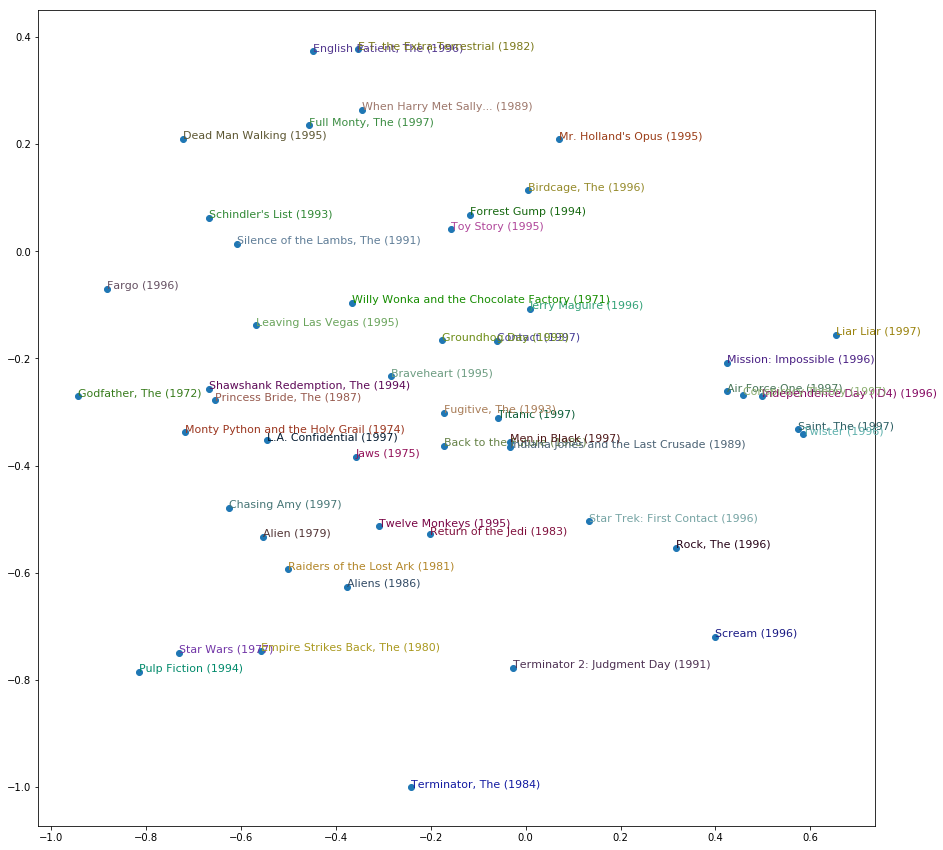

In [51]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()